In [1]:
import os

In [2]:
L1b_path = '/mnt/disks/goes-data/2020/L1b/'
CM_path = '/mnt/disks/goes-data/2020/CM/'

In [6]:
L1b_folders = os.listdir(L1b_path)
L1b_folders.sort()
CM_folders = os.listdir(CM_path)
CM_folders.sort()

In [10]:
len(CM_folders), len(L1b_folders)

(365, 365)

In [15]:
split_size = (len(L1b_folders) // 10) + 1

In [18]:
# Split the L1b folders into 10 groups and move to a different directory

for i in range(10):
    new_dir = f'/mnt/disks/goes-data/2020/split_{i}/'
    os.makedirs(new_dir, exist_ok=True)
    os.makedirs(new_dir + 'L1b/', exist_ok=True)
    os.makedirs(new_dir + 'CM/', exist_ok=True)

In [19]:
for i in range(10):
    start = i * split_size
    end = (i + 1) * split_size
    if end > len(L1b_folders):
        end = len(L1b_folders)
    new_dir_L1b = f'/mnt/disks/goes-data/2020/split_{i}/L1b/'
    new_dir_CM = f'/mnt/disks/goes-data/2020/split_{i}/CM/'
    for folder in L1b_folders[start:end]:
        os.rename(os.path.join(L1b_path, folder), os.path.join(new_dir_L1b, folder))
    for folder in CM_folders[start:end]:
        os.rename(os.path.join(CM_path, folder), os.path.join(new_dir_CM, folder))

In [12]:
# Undo changes and move all files back

for i in range(10):
    new_dir_L1b = f'/mnt/disks/goes-data/2020/split_{i}/L1b/'
    new_dir_CM = f'/mnt/disks/goes-data/2020/split_{i}/CM/'
    for folder in os.listdir(new_dir_L1b):
        os.rename(os.path.join(new_dir_L1b, folder), os.path.join(L1b_path, folder))
    for folder in os.listdir(new_dir_CM):
        os.rename(os.path.join(new_dir_CM, folder), os.path.join(CM_path, folder))
    os.rmdir(new_dir_L1b)
    os.rmdir(new_dir_CM)
    os.rmdir(f'/mnt/disks/goes-data/2020/split_{i}/')

In [11]:
import xarray as xr
import autoroot
from rs_tools._src.geoprocessing.goes.reproject import add_goes16_crs

goes_ds = xr.open_dataset('/mnt/disks/goes-geoprocessed/goes/20200208050009_goes16.nc')

/opt/conda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/opt/conda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [12]:
goes_ds

<xarray.Dataset> Size: 1GB
Dimensions:                 (band: 16, y: 3623, x: 3623, time: 1,
                             band_wavelength: 16)
Coordinates:
  * x                       (x) float64 29kB -5.433e+06 -5.43e+06 ... 5.434e+06
  * y                       (y) float64 29kB 5.433e+06 5.43e+06 ... -5.434e+06
  * time                    (time) <U16 64B '2020-02-08 05:04'
  * band_wavelength         (band_wavelength) float32 64B 0.47 0.64 ... 13.27
    latitude                (y, x) float32 53MB ...
    longitude               (y, x) float32 53MB ...
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    cloud_mask              (y, x) float64 105MB ...
Data variables:
    Rad                     (band, y, x) float32 840MB ...
    goes_imager_projection  int64 8B ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-02-08T05:09:45.7Z
    time_coverage_start:       2020-02-08T05:00:09.1Z
    time_coverage_end:         2020-02-08T05:09:39.9Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        75f7f563-5db0-4adc-9fb7-d144223b4ef8

In [13]:
# Move specific coordinate variables to data variables
goes_ds = goes_ds.reset_coords(["cloud_mask"])
goes_ds = goes_ds.drop_vars(["latitude", "longitude"])

goes_ds = add_goes16_crs(goes_ds)

goes_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.Dataset> Size: 945MB
Dimensions:                 (band: 16, y: 3623, x: 3623, time: 1,
                             band_wavelength: 16)
Coordinates:
  * x                       (x) float64 29kB -5.433e+06 -5.43e+06 ... 5.434e+06
  * y                       (y) float64 29kB 5.433e+06 5.43e+06 ... -5.434e+06
  * time                    (time) <U16 64B '2020-02-08 05:04'
  * band_wavelength         (band_wavelength) float32 64B 0.47 0.64 ... 13.27
    goes_imager_projection  int64 8B 0
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
Data variables:
    Rad                     (band, y, x) float32 840MB ...
    cloud_mask              (y, x) float64 105MB ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-02-08T05:09:45.7Z
    time_coverage_start:       2020-02-08T05:00:09.1Z
    time_coverage_end:         2020-02-08T05:09:39.9Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        75f7f563-5db0-4adc-9fb7-d144223b4ef8

In [14]:
goes_ds = add_goes16_crs(goes_ds)
# CRS
src_crs = goes_ds.rio.crs
print(f"CRS:\n{src_crs}\n")

# bounds
src_bounds = goes_ds.rio.bounds()
print(f"Bounds:\n{src_bounds}\n")

# resolution
src_resolution = goes_ds.rio.resolution()
print(f"Resolution:\n{src_resolution}\n")

# transformation
src_transform = goes_ds.rio.transform()
print(f"Transform:\n{src_transform}\n")

CRS:
PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257222096042]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +sweep=x +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"]]

Bounds:
(-5434895.004332995, -5435554.195667006, 5435554.195667006, 5434895.004332995)

Resolution:
(3000.4, -3000.4)

Transform:
| 3000.40, 0.00,-5434895.00|
| 0.00,-3000.40, 5434895.00|
| 0.00, 0.00, 1.00|



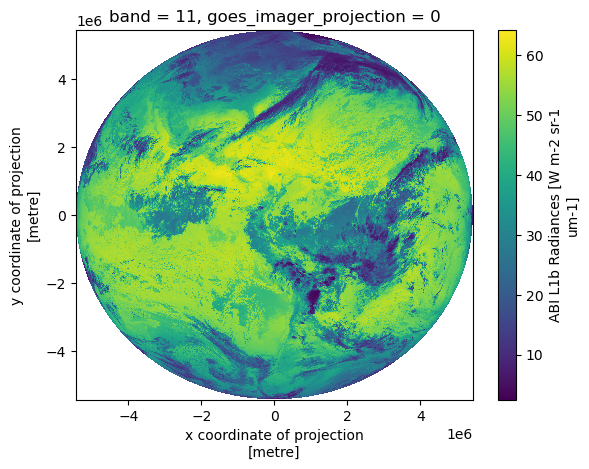

: 

In [16]:
goes_ds.Rad.isel(band=10).plot.imshow()